### Import Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Read training data
df = pd.read_excel("/Users/wangxinyi/Desktop/Kickstarter.xlsx")

display(df)
print("Initial dataset shape:", df.shape)

,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,main_category,staff_pick.1,show_feature_image,video
0,22292,Golgotha - A Feature Film,5500,5530.0,successful,False,US,USD,2017-07-09 04:59:00,2017-07-09 04:59:01,...,2011,23,6,3,2017,16,Film & Video,False,False,True
1,82234,Vinca is opening a storefront!,10000,11045.0,successful,False,US,USD,2018-10-25 14:29:30,2018-10-25 14:29:32,...,2012,21,9,25,2018,14,Fashion,False,False,True
2,86478,The next Paul Jacobsen & The Madison Arm album!,8500,10556.0,successful,False,US,USD,2019-05-05 16:37:46,2019-05-05 16:37:46,...,2012,22,4,5,2019,16,Music,False,False,True
3,127446,Erin Heist First Full-Length Album,5000,5816.0,successful,False,US,USD,2021-11-25 21:00:14,2021-11-25 21:00:14,...,2012,22,10,26,2021,20,Music,False,False,True
4,151612,Earth Day Heritage: A Celebration in Music and...,15000,2361.0,failed,False,US,USD,2021-04-15 21:22:00,2021-04-15 21:22:00,...,2012,21,3,15,2021,19,Music,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15210,4533276,AN SCP LIVE ACTION MINI SERIES,2000,2002.0,successful,False,GB,GBP,2023-10-18 17:41:20,2023-10-18 17:41:20,...,2022,16,9,18,2023,17,Film & Video,False,False,True
15211,4533396,Seaworthy Seductions - Art Exhibit + Community...,5000,5791.0,successful,False,US,USD,2023-04-01 03:11:00,2023-04-01 03:11:00,...,2022,21,3,6,2023,23,Art,False,False,True
15212,4533462,The Second Coming,500,526.0,successful,False,US,USD,2023-04-20 07:15:27,2023-04-20 07:15:27,...,2022,1,3,31,2023,7,Music,False,False,True
15213,4533499,Eugene Art House presents: The Films of Federi...,5975,6537.0,successful,False,US,USD,2023-01-25 07:59:00,2023-01-25 07:59:00,...,2022,3,1,1,2023,22,Film & Video,False,False,True


Initial dataset shape: (15215, 46)


### Data Preprocessing

In [3]:
# Filter for successful/failed projects only
df = df[df['state'].isin(['successful', 'failed'])]
print("\nDataset shape after filtering for successful/failed:", df.shape)

# Check for nulls
print("Initial null value counts:")
print(df.isnull().sum())



Dataset shape after filtering for successful/failed: (14463, 46)
Initial null value counts:
id                            0
name                          0
goal                          0
pledged                       0
state                         0
disable_communication         0
country                       0
currency                      0
deadline                      0
state_changed_at              0
created_at                    0
launched_at                   0
staff_pick                    0
backers_count                 0
static_usd_rate               0
usd_pledged                   0
category                      0
spotlight                     0
name_len                      0
name_len_clean                0
blurb_len                     0
blurb_len_clean               0
deadline_weekday              0
state_changed_at_weekday      0
created_at_weekday            0
launched_at_weekday           0
deadline_month                0
deadline_day                  0
deadline_yr

In [4]:
# First get the mapping
category_to_main = df[df['main_category'].notna()].groupby('category')['main_category'].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None)

# Create the mapping dictionary explicitly
category_main_dict = category_to_main.to_dict()

# Now fill the nulls using the mapping with error handling
df['main_category'] = df.apply(lambda row: category_main_dict.get(row['category'], 'Unknown') 
                             if pd.isnull(row['main_category']) 
                             else row['main_category'], axis=1)

print("\nRemaining nulls after filling:", df['main_category'].isnull().sum())
print("\nUpdated main category distribution:")
print(df['main_category'].value_counts())


Remaining nulls after filling: 0

Updated main category distribution:
main_category
Film & Video    2039
Publishing      1706
Music           1606
Art             1469
Food            1457
Fashion         1270
Technology      1157
Games            811
Crafts           700
Photography      652
Design           488
Journalism       400
Unknown          278
Theater          187
Comics           141
Dance            102
Name: count, dtype: int64


In [5]:
# Drop variables that would not be available at launch time
post_launch_columns = ['pledged', 'disable_communication', 'state_changed_at', 'backers_count', 'usd_pledged',
                      'state_changed_at_weekday', 'state_changed_at_month', 
                      'state_changed_at_day', 'state_changed_at_yr', 'state_changed_at_hr',
                      'spotlight', 'staff_pick', 'staff_pick.1']
df = df.drop(columns=post_launch_columns)

### EDA


Unique values in category: 145


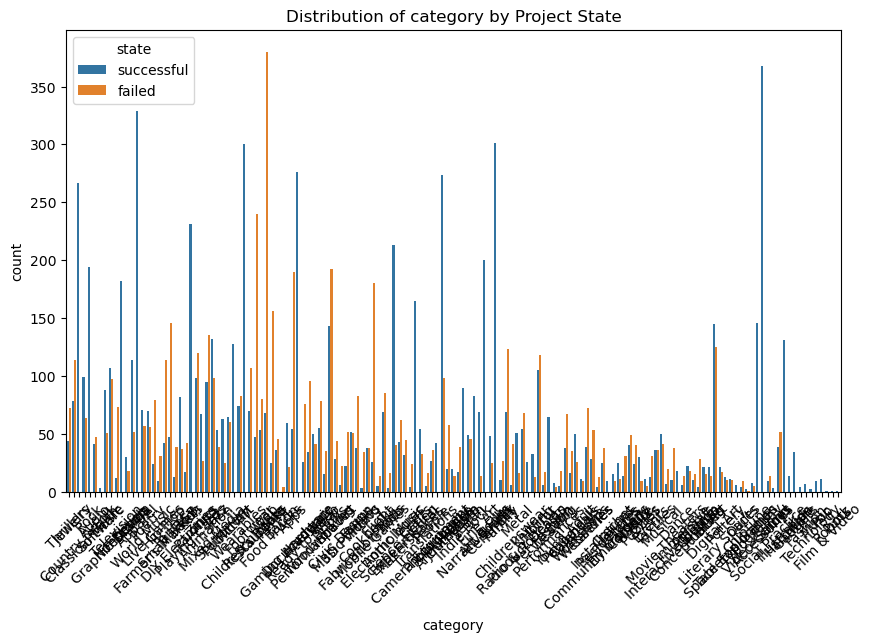


Unique values in country: 115


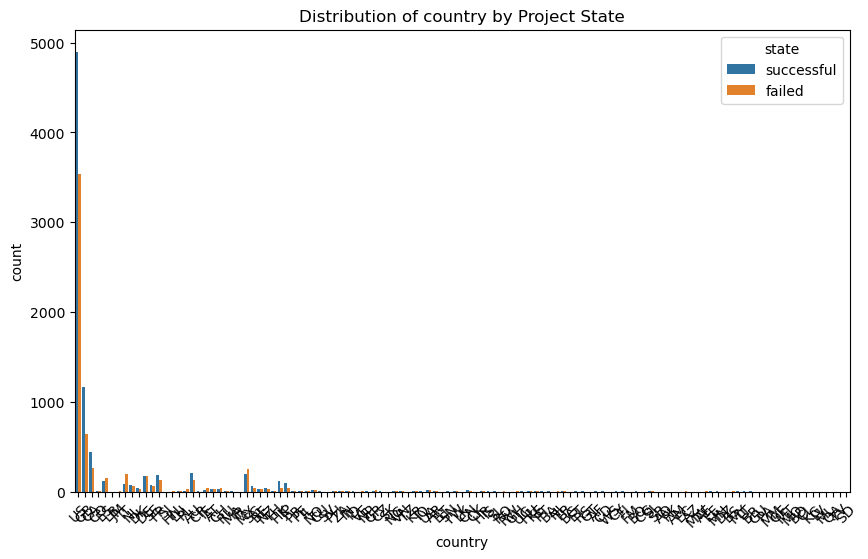


Unique values in currency: 15


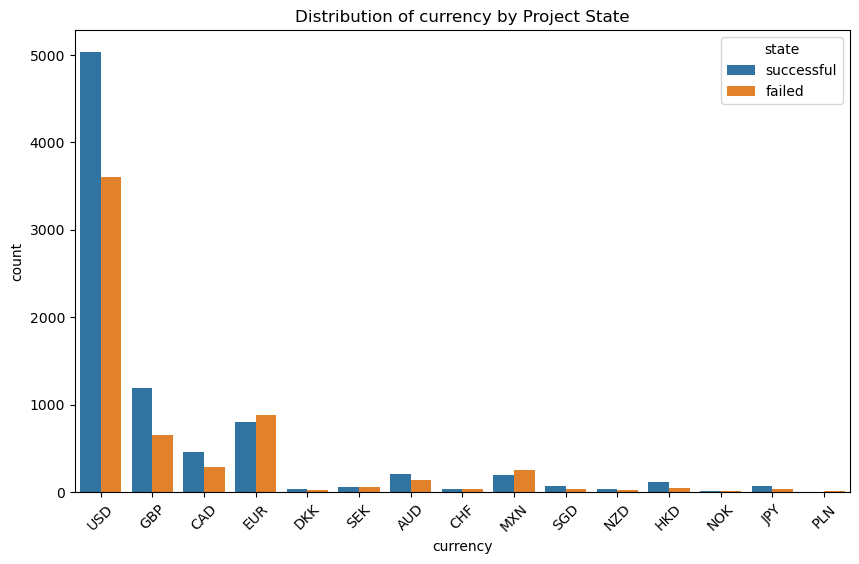


Unique values in main_category: 16


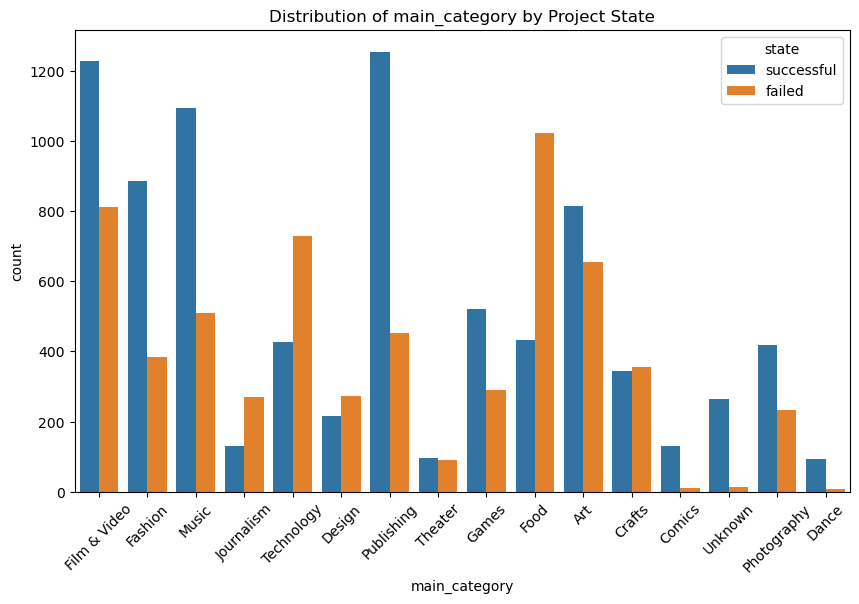


Unique values in show_feature_image: 2


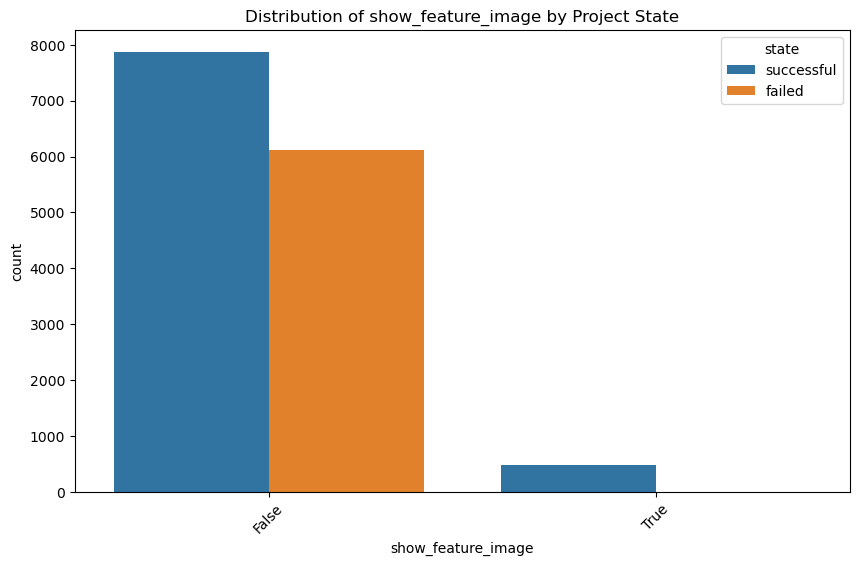


Unique values in video: 2


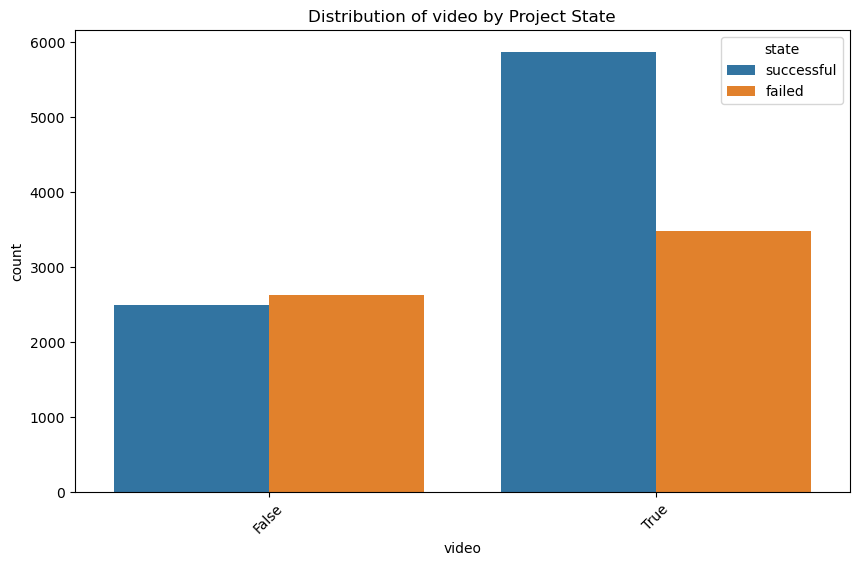


Summary statistics for goal:
             count           mean           std  min     25%      50%  \
state                                                                   
failed      6112.0  122047.272251  2.089049e+06  1.0  3000.0  10000.0   
successful  8351.0   30478.828763  1.115606e+06  1.0  1000.0   3750.0   

                75%          max  
state                             
failed      28275.0  100000000.0  
successful  10000.0  100000000.0  


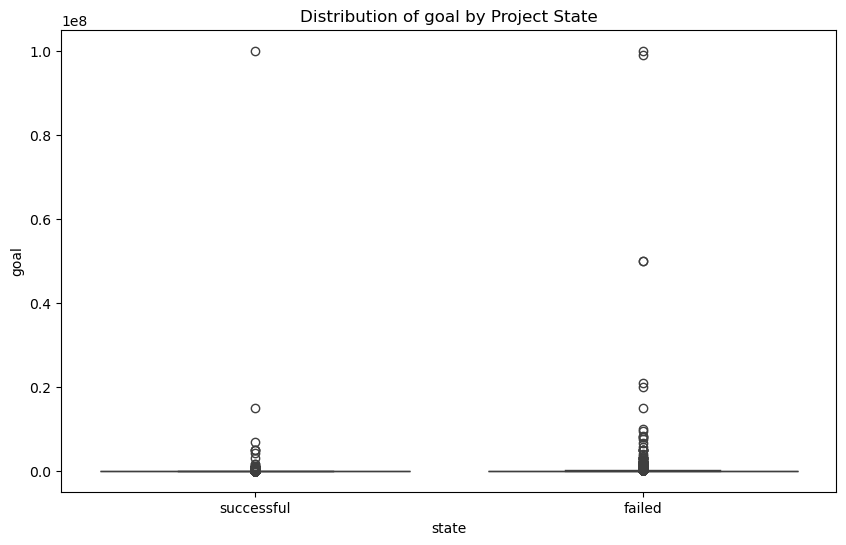


Summary statistics for name_len:
             count      mean       std  min  25%  50%  75%   max
state                                                           
failed      6112.0  5.097513  2.491678  1.0  3.0  5.0  7.0  13.0
successful  8351.0  5.579452  2.415247  1.0  4.0  5.0  7.0  16.0


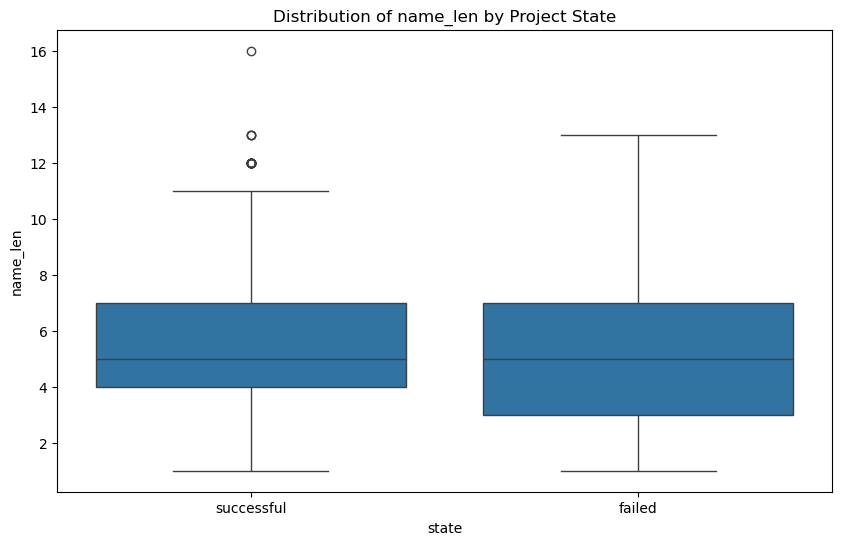


Summary statistics for name_len_clean:
             count      mean       std  min  25%  50%  75%   max
state                                                           
failed      6112.0  4.771924  2.324025  1.0  3.0  5.0  7.0  13.0
successful  8351.0  5.174470  2.232498  1.0  3.0  5.0  7.0  14.0


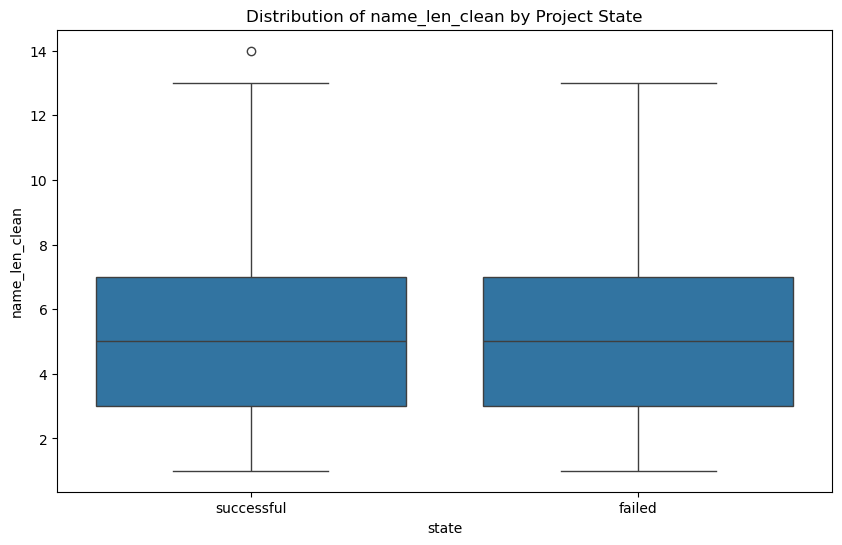


Summary statistics for blurb_len:
             count       mean       std  min   25%   50%   75%   max
state                                                               
failed      6112.0  16.740674  6.039064  1.0  13.0  18.0  21.0  31.0
successful  8351.0  15.998563  5.717648  1.0  12.0  17.0  20.0  30.0


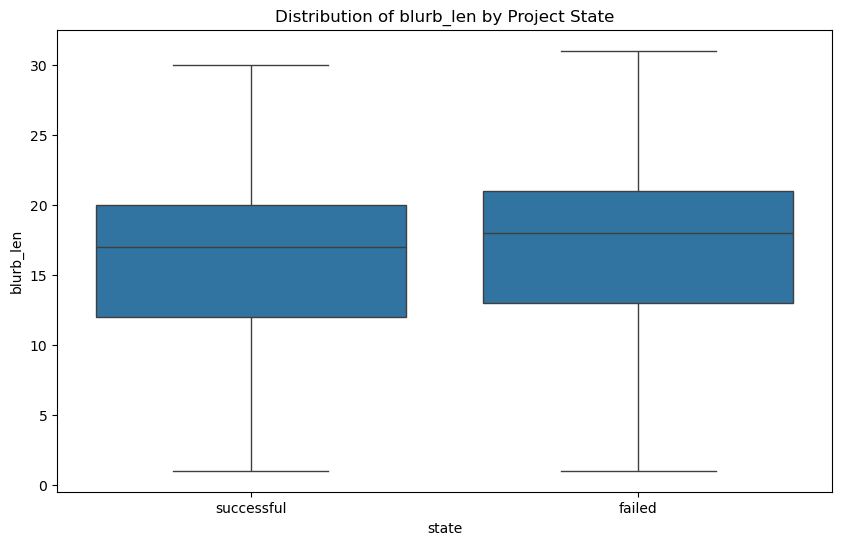


Summary statistics for blurb_len_clean:
             count       mean       std  min   25%   50%   75%   max
state                                                               
failed      6112.0  15.412631  5.624120  1.0  11.0  17.0  20.0  28.0
successful  8351.0  14.655969  5.308547  1.0  11.0  16.0  19.0  28.0


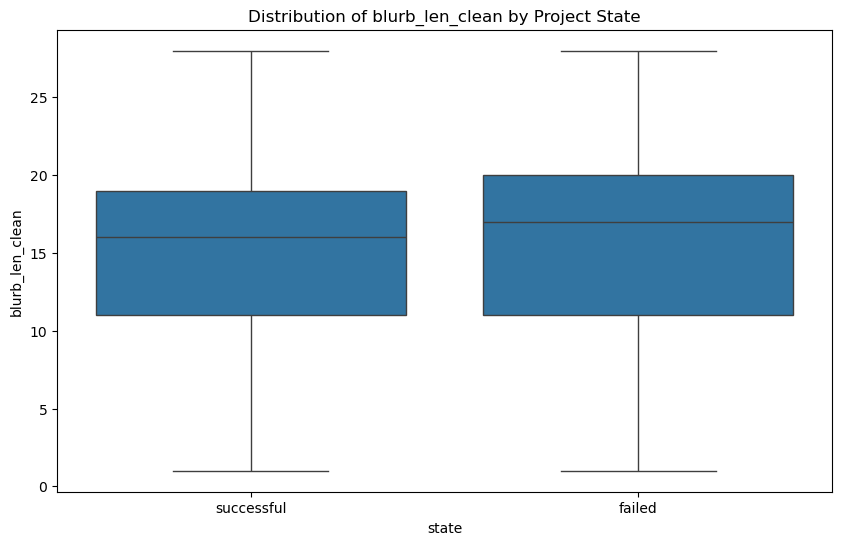

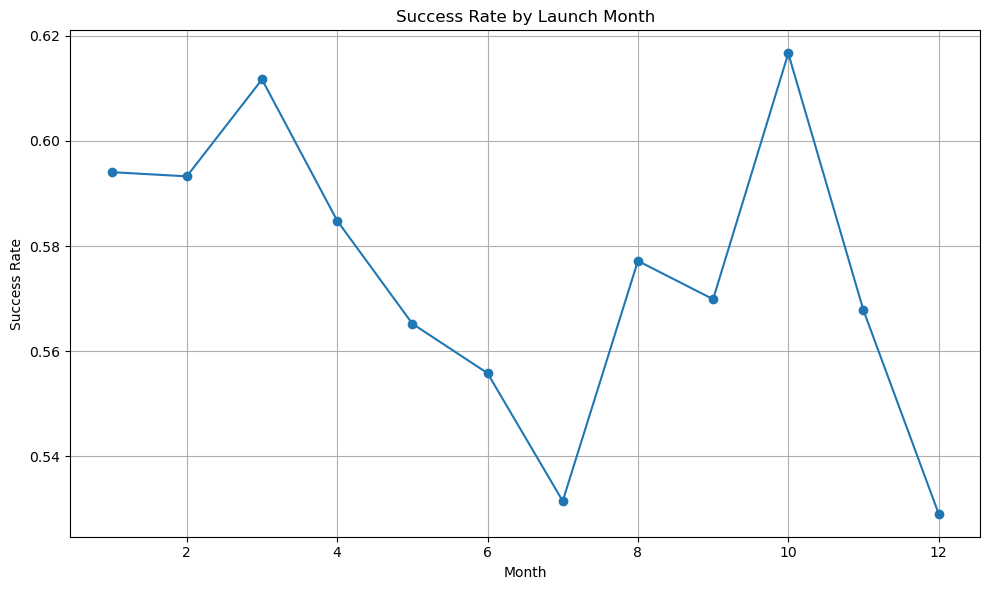


Most common categories:
main_category
Film & Video    2039
Publishing      1706
Music           1606
Art             1469
Food            1457
Name: count, dtype: int64

Most common countries:
country
US    8435
GB    1801
CA     705
MX     451
DE     349
Name: count, dtype: int64

Success rate with/without video:
video
False    0.486317
True     0.627260
Name: state, dtype: float64

Success rate with/without feature image:
show_feature_image
False    0.562835
True     1.000000
Name: state, dtype: float64


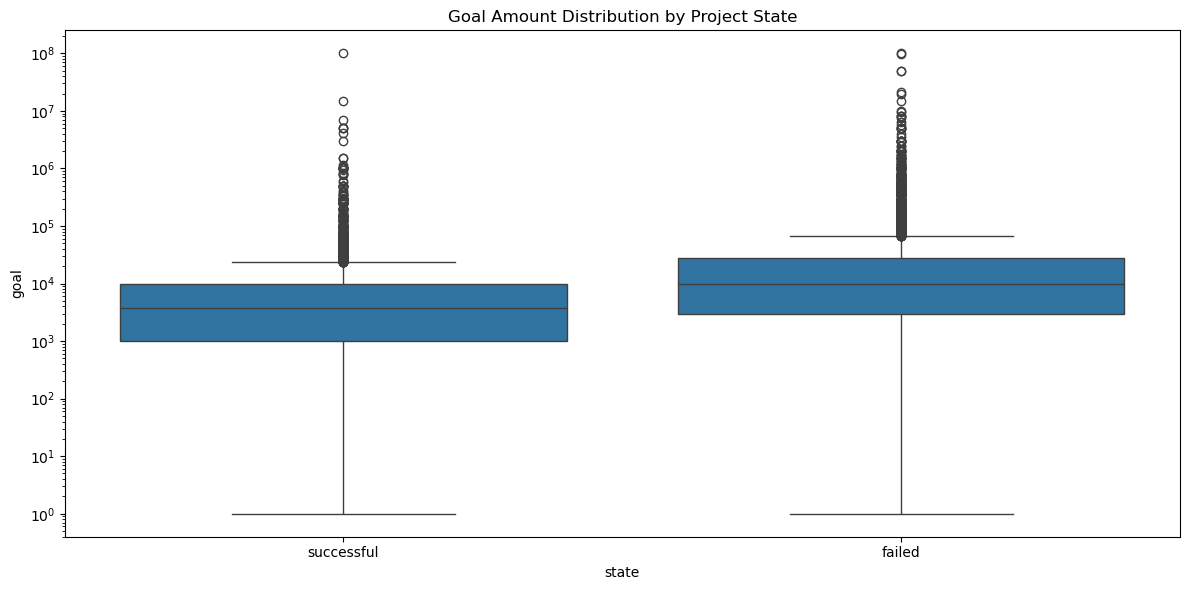

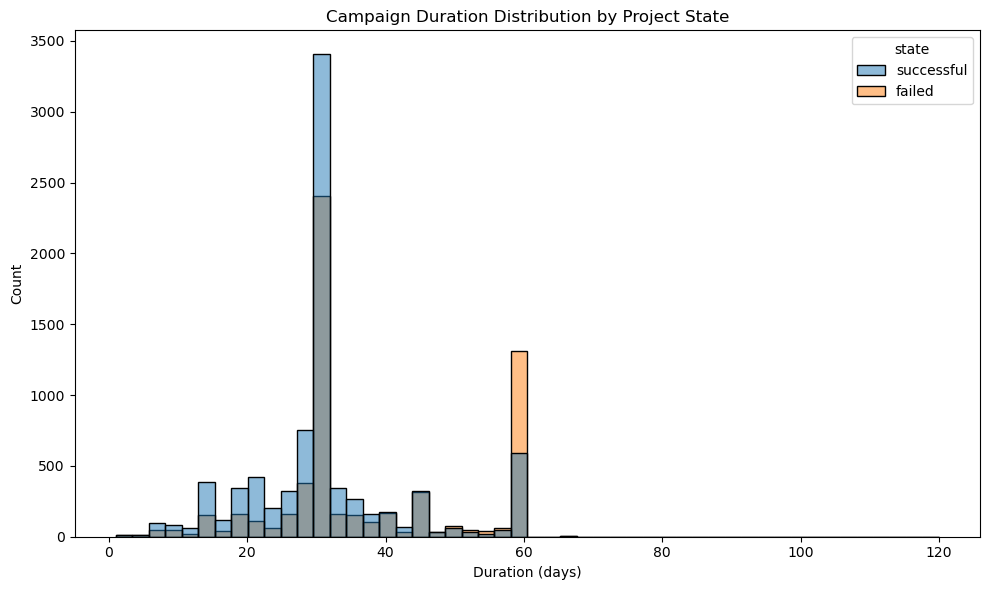


Model Performance:
Accuracy: 0.7352229519529899

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      1273
           1       0.73      0.84      0.78      1620

    accuracy                           0.74      2893
   macro avg       0.74      0.72      0.72      2893
weighted avg       0.74      0.74      0.73      2893



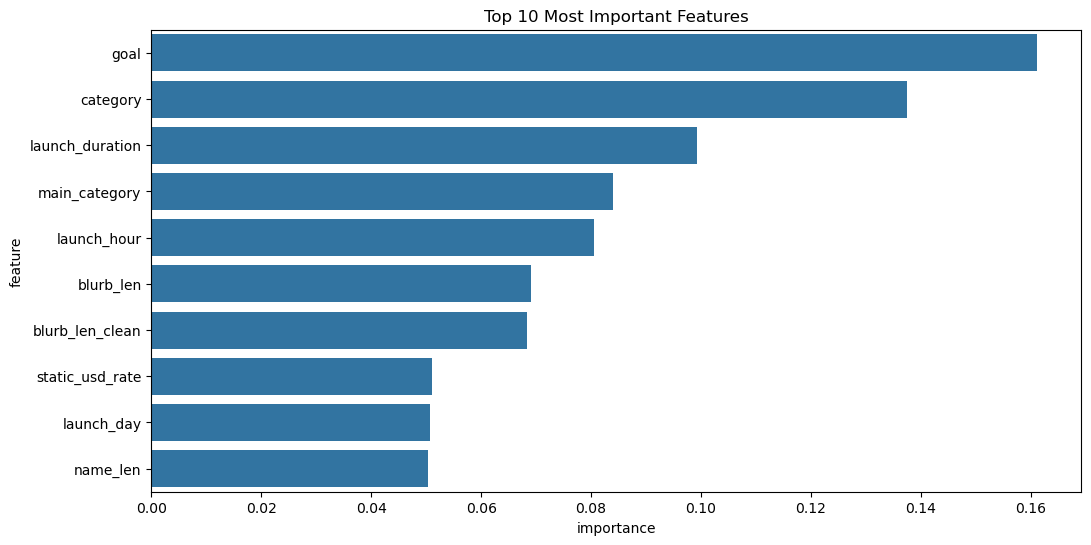

In [8]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# EDA Functions
def plot_categorical_distribution(data, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, hue='state')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {column} by Project State')
    plt.show()

def plot_numerical_distribution(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='state', y=column)
    plt.title(f'Distribution of {column} by Project State')
    plt.show()

# Analyze categorical variables
categorical_cols = ['category','country', 'currency', 'main_category', 
                    'show_feature_image', 'video']

for col in categorical_cols:
    print(f"\nUnique values in {col}:", df[col].nunique())
    plot_categorical_distribution(df, col)

# Analyze numerical variables available at launch
numerical_cols = ['goal', 'name_len', 'name_len_clean',
                 'blurb_len', 'blurb_len_clean']

for col in numerical_cols:
    print(f"\nSummary statistics for {col}:")
    print(df.groupby('state')[col].describe())
    plot_numerical_distribution(df, col)

# Success rate by launch month
monthly_success = df.groupby('launched_at_month')['state'].apply(
    lambda x: (x == 'successful').mean()
)

plt.figure(figsize=(10, 6))
monthly_success.plot(kind='line', marker='o')
plt.title('Success Rate by Launch Month')
plt.xlabel('Month')
plt.ylabel('Success Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional insights about categorical features
print("\nMost common categories:")
print(df['main_category'].value_counts().head())

print("\nMost common countries:")
print(df['country'].value_counts().head())

# Video and image feature analysis
print("\nSuccess rate with/without video:")
print(df.groupby('video')['state'].apply(
    lambda x: (x == 'successful').mean()
))

print("\nSuccess rate with/without feature image:")
print(df.groupby('show_feature_image')['state'].apply(
    lambda x: (x == 'successful').mean()
))

# Goal amount analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='goal', data=df)
plt.title('Goal Amount Distribution by Project State')
plt.yscale('log')  # Using log scale due to likely skewed distribution
plt.tight_layout()
plt.show()

# Time-based analysis
df['launched_at'] = pd.to_datetime(df['launched_at'])
df['deadline'] = pd.to_datetime(df['deadline'])
df['campaign_duration'] = (df['deadline'] - df['launched_at']).dt.days

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='campaign_duration', hue='state', bins=50)
plt.title('Campaign Duration Distribution by Project State')
plt.xlabel('Duration (days)')
plt.tight_layout()
plt.show()

# Feature Engineering
def extract_time_features(df):
    # Convert launch time to hour of day and day of week
    df['launch_hour'] = pd.to_datetime(df['launched_at']).dt.hour
    df['launch_day'] = pd.to_datetime(df['launched_at']).dt.dayofweek
    return df

def calculate_campaign_duration(df):
    # Calculate campaign duration in days
    df['launch_duration'] = (pd.to_datetime(df['deadline']) - 
                             pd.to_datetime(df['launched_at'])).dt.days
    return df

# Prepare features for modeling
def prepare_features(df):
    # Select features available at launch time
    features = ['goal', 'static_usd_rate', 'name_len', 'name_len_clean',
               'blurb_len', 'blurb_len_clean', 'main_category', 'category','country',
               'currency', 'show_feature_image', 'video',
               'launch_hour', 'launch_day', 'launch_duration']
    
    X = df[features].copy()
    y = (df['state'] == 'successful').astype(int)
    
    # Encode categorical variables
    categorical_features = ['main_category', 'country', 'currency','category']
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
    
    # Convert boolean columns to integer
    boolean_features = ['show_feature_image', 'video']
    for col in boolean_features:
        X[col] = X[col].astype(int)
    
    return X, y

# Apply feature engineering
df = extract_time_features(df)
df = calculate_campaign_duration(df)

# Prepare features and target
X, y = prepare_features(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
numerical_features = ['goal', 'static_usd_rate', 'name_len', 'name_len_clean',
                     'blurb_len', 'blurb_len_clean', 'launch_hour', 'launch_day',
                     'launch_duration']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

### Chi-Square and ANOVA Test

In [10]:
# Import Dataset
from scipy.stats import chi2_contingency, f_oneway
from scipy import stats

# Function for Chi-square test
def perform_chi_square_test(data, categorical_var, target_var='state'):
    # Create contingency table
    contingency_table = pd.crosstab(data[categorical_var], data[target_var])
    
    # Perform chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    cramer_v = np.sqrt(chi2 / (n * min_dim))
    
    print(f"\nChi-square test results for {categorical_var}:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Cramer's V: {cramer_v:.4f}")
    
    return {
        'variable': categorical_var,
        'chi2': chi2,
        'p_value': p_value,
        'cramer_v': cramer_v
    }

# Function for ANOVA test
def perform_anova_test(data, numerical_var, target_var='state'):
    # Split data by target variable
    groups = [group[numerical_var].dropna() for name, group in data.groupby(target_var)]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    
    # Calculate effect size (Eta-squared)
    df_total = len(data) - 1
    df_between = len(groups) - 1
    ss_between = sum(len(group) * ((group.mean() - data[numerical_var].mean())**2) for group in groups)
    ss_total = sum((data[numerical_var] - data[numerical_var].mean())**2)
    eta_squared = ss_between / ss_total
    
    print(f"\nANOVA test results for {numerical_var}:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Eta-squared: {eta_squared:.4f}")
    
    return {
        'variable': numerical_var,
        'f_stat': f_stat,
        'p_value': p_value,
        'eta_squared': eta_squared
    }

# Categorical variables for Chi-square test
categorical_vars = [
    'main_category',
    'country',
    'currency',
    'category',
    'show_feature_image',
    'video'
]

# Numerical variables for ANOVA
numerical_vars = [
    'goal',
    'name_len',
    'name_len_clean',
    'blurb_len',
    'blurb_len_clean'
]

# Perform Chi-square tests
chi_square_results = []
for var in categorical_vars:
    result = perform_chi_square_test(df, var)
    chi_square_results.append(result)

# Perform ANOVA tests
anova_results = []
for var in numerical_vars:
    result = perform_anova_test(df, var)
    anova_results.append(result)

# Create summary tables
chi_square_summary = pd.DataFrame(chi_square_results)
chi_square_summary = chi_square_summary.sort_values('cramer_v', ascending=False)

anova_summary = pd.DataFrame(anova_results)
anova_summary = anova_summary.sort_values('eta_squared', ascending=False)

print("\nChi-square tests summary (sorted by effect size):")
print(chi_square_summary)

print("\nANOVA tests summary (sorted by effect size):")
print(anova_summary)


Chi-square test results for main_category:
Chi-square statistic: 1467.7101
p-value: 0.0000
Degrees of freedom: 15
Cramer's V: 0.3186

Chi-square test results for country:
Chi-square statistic: 357.7613
p-value: 0.0000
Degrees of freedom: 114
Cramer's V: 0.1573

Chi-square test results for currency:
Chi-square statistic: 180.3245
p-value: 0.0000
Degrees of freedom: 14
Cramer's V: 0.1117

Chi-square test results for category:
Chi-square statistic: 5111.7731
p-value: 0.0000
Degrees of freedom: 144
Cramer's V: 0.5945

Chi-square test results for show_feature_image:
Chi-square statistic: 363.1427
p-value: 0.0000
Degrees of freedom: 1
Cramer's V: 0.1585

Chi-square test results for video:
Chi-square statistic: 268.5912
p-value: 0.0000
Degrees of freedom: 1
Cramer's V: 0.1363

ANOVA test results for goal:
F-statistic: 11.5460
p-value: 0.0007
Eta-squared: 0.0008

ANOVA test results for name_len:
F-statistic: 136.7987
p-value: 0.0000
Eta-squared: 0.0094

ANOVA test results for name_len_clean:


### Correlation Matrix


Features available at launch time:
['goal', 'country', 'currency', 'category', 'main_category', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'launched_at_weekday', 'launched_at_month', 'launched_at_hr', 'show_feature_image', 'video']


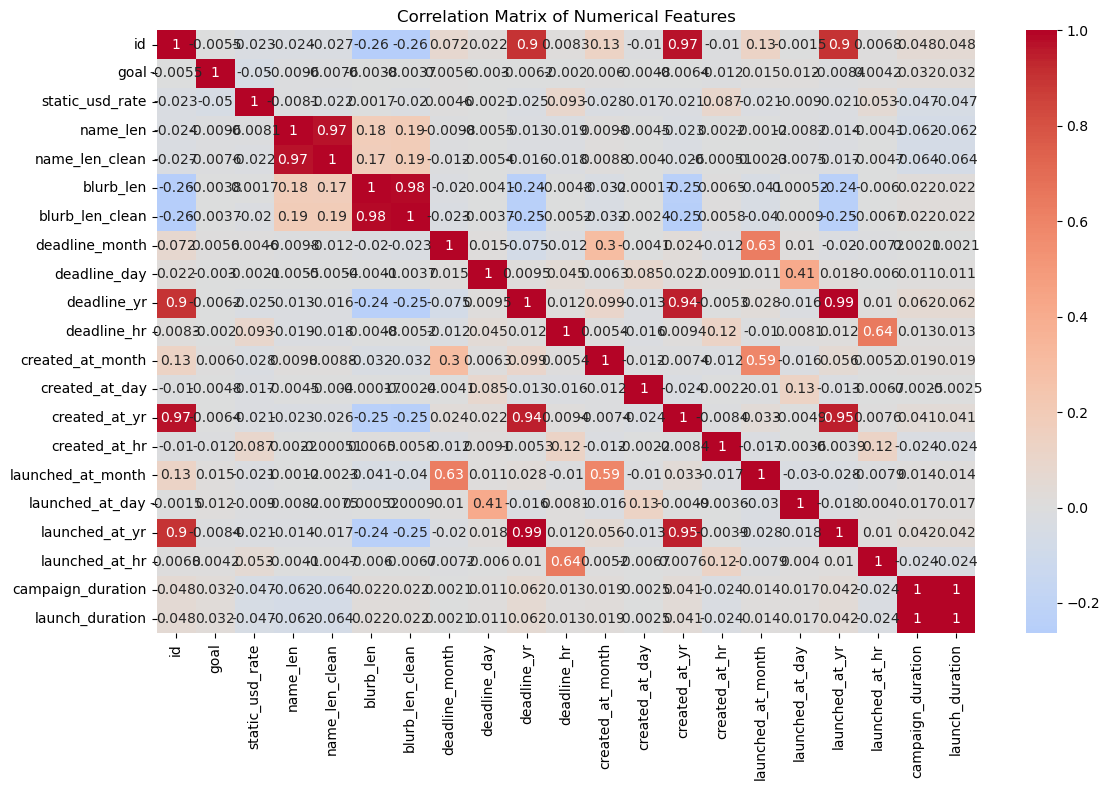

In [11]:
# Feature availability analysis
print("\nFeatures available at launch time:")
launch_features = [
    'goal', 'country', 'currency', 'category', 'main_category',
    'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean',
    'launched_at_weekday', 'launched_at_month', 'launched_at_hr',
    'show_feature_image', 'video'
]
print(launch_features)

# Correlation analysis for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### Feature Engineering

In [12]:
# --- Feature Engineering ---
# Convert goal to USD
df['goal_usd'] = df['goal'] * df['static_usd_rate']

# Temporal features
df['launch_duration'] = (df['deadline'] - df['launched_at']).dt.days
df['creation_to_launch'] = (df['launched_at'] - df['created_at']).dt.days

# Log transformation for goal in USD
df['log_goal_usd'] = np.log1p(df['goal_usd'])

# Interaction feature: USD goal-to-duration ratio
df['goal_to_duration_ratio_usd'] = df['goal_usd'] / (df['launch_duration'] + 1)

weekday_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['launched_at_weekday'] = df['launched_at_weekday'].map(weekday_mapping)

# Keep only the rows where state is 'successful' or 'failed'
df = df[df['state'].isin(['successful', 'failed'])]

# Encode target variable
df['state'] = df['state'].map({'successful': 1, 'failed': 0})

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['category', 'country'], drop_first=True)

In [13]:
# Select relevant features
encoded_features = [col for col in df.columns if 'category_' in col or 'country_' in col]

final_features = [
    'launch_duration', 'creation_to_launch',
    'launched_at_weekday', 'name_len_clean', 'blurb_len_clean',
    'log_goal_usd', 'show_feature_image', 'video'
] + encoded_features

### Model Development

In [14]:
# Prepare Features
X = df[final_features]
y = df['state']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Standardization ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# --- Random Forest Classifier ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

print("Random Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions)}")
print("Classification Report:")
print(classification_report(y_test, rf_predictions))

Random Forest Results:
Accuracy: 0.7455928102315935
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.51      0.63      1223
           1       0.72      0.92      0.81      1670

    accuracy                           0.75      2893
   macro avg       0.77      0.71      0.72      2893
weighted avg       0.76      0.75      0.73      2893



In [16]:
# --- Gradient Boosting Classifier with Hyperparameter Tuning ---
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_tuned = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
gb_tuned.fit(X_train, y_train)

gb_predictions = gb_tuned.best_estimator_.predict(X_test)

print("\nGradient Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, gb_predictions)}")
print("Best Parameters:", gb_tuned.best_params_)
print("Classification Report:")
print(classification_report(y_test, gb_predictions))


Gradient Boosting Results:
Accuracy: 0.7957137919115106
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1223
           1       0.81      0.85      0.83      1670

    accuracy                           0.80      2893
   macro avg       0.79      0.79      0.79      2893
weighted avg       0.79      0.80      0.79      2893



In [17]:
# --- Logistic Regression ---
lr_model = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions)}")
print("Classification Report:")
print(classification_report(y_test, lr_predictions))


Logistic Regression Results:
Accuracy: 0.7915658486000692
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1223
           1       0.82      0.81      0.82      1670

    accuracy                           0.79      2893
   macro avg       0.79      0.79      0.79      2893
weighted avg       0.79      0.79      0.79      2893



In [18]:
# --- Lasso Logistic Regression ---
lasso_model = LogisticRegression(random_state=42, penalty='l1', solver='liblinear', C=0.1)
lasso_model.fit(X_train, y_train)
lasso_predictions = lasso_model.predict(X_test)

print("\nLasso Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, lasso_predictions)}")
print("Classification Report:")
print(classification_report(y_test, lasso_predictions))


Lasso Logistic Regression Results:
Accuracy: 0.7753197372969236
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1223
           1       0.81      0.80      0.81      1670

    accuracy                           0.78      2893
   macro avg       0.77      0.77      0.77      2893
weighted avg       0.78      0.78      0.78      2893



In [19]:
# --- Ensemble Model ---
ensemble_model = VotingClassifier(estimators=[
    ('gb', gb_tuned.best_estimator_),
    ('rf', rf_model),
    ('lr', lr_model)
], voting='soft')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

print("\nEnsemble Model Results:")
print(f"Accuracy: {accuracy_score(y_test, ensemble_predictions)}")
print("Classification Report:")
print(classification_report(y_test, ensemble_predictions))



Ensemble Model Results:
Accuracy: 0.7950224680262703
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      1223
           1       0.80      0.86      0.83      1670

    accuracy                           0.80      2893
   macro avg       0.79      0.78      0.79      2893
weighted avg       0.79      0.80      0.79      2893



### Cross-Validation

In [20]:
# Gradient Boosting with Cross Validation
from sklearn.model_selection import cross_validate

# Define parameters for grid search
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# Initialize base model
gb_base = GradientBoostingClassifier(random_state=42)

# Perform GridSearchCV
gb_tuned = GridSearchCV(
    gb_base, 
    param_grid,
    cv=5,
    scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
    refit='f1_weighted',
    n_jobs=-1
)

# Fit the model
gb_tuned.fit(X_train, y_train)

# Get cross-validation results
cv_results = pd.DataFrame(gb_tuned.cv_results_)
print("\nCross-Validation Results Summary:")
print("\nBest Parameters:", gb_tuned.best_params_)
print("\nMean Cross-Validation Scores:")
print(f"Accuracy: {cv_results['mean_test_accuracy'][gb_tuned.best_index_]:.4f}")
print(f"Precision: {cv_results['mean_test_precision_weighted'][gb_tuned.best_index_]:.4f}")
print(f"Recall: {cv_results['mean_test_recall_weighted'][gb_tuned.best_index_]:.4f}")
print(f"F1: {cv_results['mean_test_f1_weighted'][gb_tuned.best_index_]:.4f}")

# Final test set evaluation
gb_predictions = gb_tuned.predict(X_test)
print("\nTest Set Results:")
print(classification_report(y_test, gb_predictions))


Cross-Validation Results Summary:

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

Mean Cross-Validation Scores:
Accuracy: 0.7886
Precision: 0.7876
Recall: 0.7886
F1: 0.7874

Test Set Results:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      1223
           1       0.81      0.85      0.83      1670

    accuracy                           0.80      2893
   macro avg       0.79      0.79      0.79      2893
weighted avg       0.79      0.80      0.79      2893



### Grading

In [23]:
# Import and preprocess grading data
grading_df = pd.read_excel("Kickstarter-Grading.xlsx")

# Apply same preprocessing steps to grading data
grading_df = grading_df[grading_df['state'].isin(['successful', 'failed'])]

# Convert goal to USD
grading_df['goal_usd'] = grading_df['goal'] * grading_df['static_usd_rate']

# Temporal features
grading_df['launch_duration'] = (grading_df['deadline'] - grading_df['launched_at']).dt.days
grading_df['creation_to_launch'] = (grading_df['launched_at'] - grading_df['created_at']).dt.days

# Log transformation for goal in USD
grading_df['log_goal_usd'] = np.log1p(grading_df['goal_usd'])

# Interaction feature
grading_df['goal_to_duration_ratio_usd'] = grading_df['goal_usd'] / (grading_df['launch_duration'] + 1)

# Apply same weekday mapping
grading_df['launched_at_weekday'] = grading_df['launched_at_weekday'].map(weekday_mapping)

# Encode target variable
grading_df['state'] = grading_df['state'].map({'successful': 1, 'failed': 0})

# One-hot encode categorical features
grading_df = pd.get_dummies(grading_df, columns=['category', 'country'], drop_first=True)

# Ensure grading data has all necessary columns
missing_cols = set(X.columns) - set(grading_df.columns)
for col in missing_cols:
    grading_df[col] = 0

# Select same features as training
X_grading = grading_df[final_features]
y_grading = grading_df['state']

# Make predictions using the trained model
grading_predictions = gb_tuned.predict(X_grading)
grading_accuracy = accuracy_score(y_grading, grading_predictions)
print("\nModel Performance on Grading Set:")
print(f"Accuracy: {grading_accuracy:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'Kickstarter-Grading.xlsx'